In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import random

# data
import datetime
import itertools
import json

In [5]:
from features_yj import Features

In [6]:
t = Features()
train = t.run_all()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 35378
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   방송일시                  35379 non-null  datetime64[ns]
 1   노출(분)                 20403 non-null  float64       
 2   마더코드                  35379 non-null  object        
 3   상품코드                  35379 non-null  object        
 4   상품명                   35379 non-null  object        
 5   상품군                   35379 non-null  object        
 6   판매단가                  35379 non-null  float64       
 7   취급액                   35379 non-null  float64       
 8   exposed               35379 non-null  float64       
 9   ymd                   35379 non-null  object        
 10  volume                35379 non-null  float64       
 11  years                 35379 non-null  int64         
 12  months                35379 non-null  int64         
 13  days            

## NA imputation for lag - zero

In [13]:
train2 = train.copy()
lag_colnum = [40,41,42,43,44,45,46,47,48,49]
for col in lag_colnum:
    train2.iloc[:,col] = train2.iloc[:,col].fillna(0)

## Turn lag price variables to rate (0~1)

In [16]:
lag_price_colnum = [40,42,44,46,48,50,51]
for col in lag_price_colnum:
    train2.iloc[:,col] = train2.iloc[:,col]/train2.iloc[:,6]

In [17]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 35378
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   방송일시                  35379 non-null  datetime64[ns]
 1   노출(분)                 20403 non-null  float64       
 2   마더코드                  35379 non-null  object        
 3   상품코드                  35379 non-null  object        
 4   상품명                   35379 non-null  object        
 5   상품군                   35379 non-null  object        
 6   판매단가                  35379 non-null  float64       
 7   취급액                   35379 non-null  float64       
 8   exposed               35379 non-null  float64       
 9   ymd                   35379 non-null  object        
 10  volume                35379 non-null  float64       
 11  years                 35379 non-null  int64         
 12  months                35379 non-null  int64         
 13  days            

In [19]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

0.0    11073
1.0     8024
2.0     7703
3.0     5222
4.0     2155
5.0      923
6.0      240
7.0       36
8.0        3
Name: lag_scode_count, dtype: int64

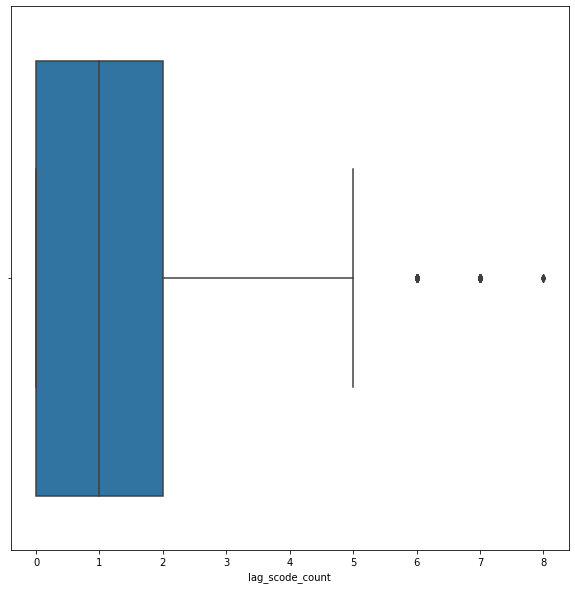

In [29]:
plt.figure(figsize=(10,10))
sns.boxplot(train2.iloc[:,41])
pd.value_counts(train2['lag_scode_count'])

## erase 'lag_scode_price'

In [31]:
train2 = train2.drop(columns = 'lag_scode_price')

## corr plot

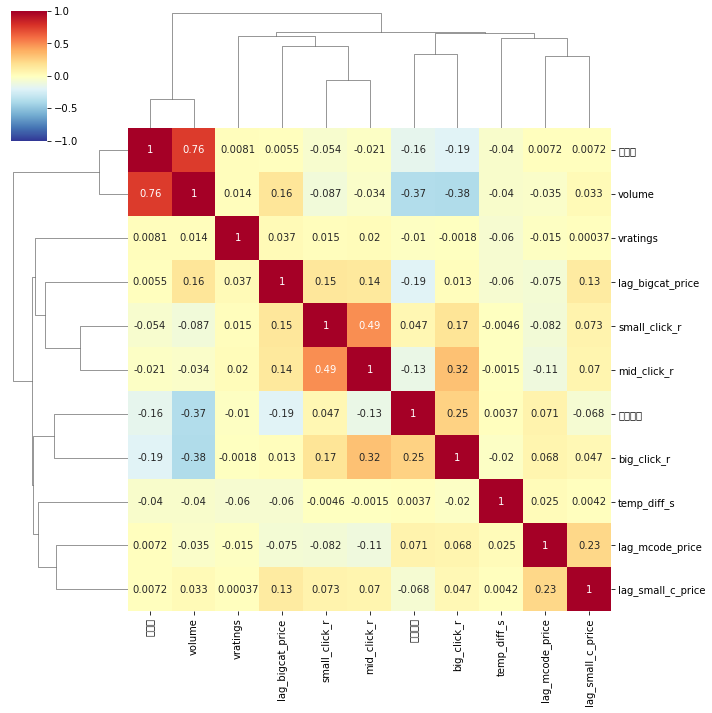

In [43]:
numeric_colnum = [6,7,10,41,43,47,56,61,62,63,65]
raw = train2.iloc[:,numeric_colnum]
df = raw.corr()

sns.clustermap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [32]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 35378
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   방송일시                  35379 non-null  datetime64[ns]
 1   노출(분)                 20403 non-null  float64       
 2   마더코드                  35379 non-null  object        
 3   상품코드                  35379 non-null  object        
 4   상품명                   35379 non-null  object        
 5   상품군                   35379 non-null  object        
 6   판매단가                  35379 non-null  float64       
 7   취급액                   35379 non-null  float64       
 8   exposed               35379 non-null  float64       
 9   ymd                   35379 non-null  object        
 10  volume                35379 non-null  float64       
 11  years                 35379 non-null  int64         
 12  months                35379 non-null  int64         
 13  days            

In [36]:
pd.value_counts(train2['temp_diff_s'])

10.4    722
11.0    701
12.7    691
9.8     689
7.5     688
       ... 
8.1      77
6.7      75
6.3      72
6.3      72
5.1      70
Name: temp_diff_s, Length: 163, dtype: int64

## outlier detection using Isolation Forest

In [57]:
from sklearn.ensemble import IsolationForest


feature_set = raw.copy()
# identify outliers in the training dataset
iso = IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.1),max_features=1.0)
iso.fit(feature_set)
pred = iso.predict(feature_set)
feature_set['anomaly']=pred
outliers=feature_set.loc[feature_set['anomaly']==-1]
outlier_index=list(outliers.index)

In [60]:
len(outlier_index)

3538

<AxesSubplot:xlabel='취급액'>

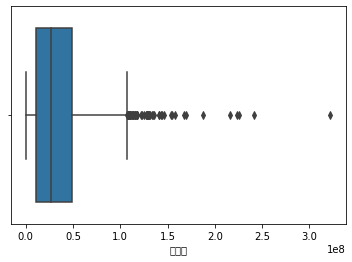

In [63]:
sns.boxplot(feature_set.iloc[outlier_index,1])

In [66]:
feature_set = raw.copy().iloc[:,[0,1,2,6,10]]
# identify outliers in the training dataset
iso = IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.05),max_features=1.0)
iso.fit(feature_set)
pred = iso.predict(feature_set)
feature_set['anomaly']=pred
outliers=feature_set.loc[feature_set['anomaly']==-1]
outlier_index=list(outliers.index)

In [67]:
len(outlier_index)

1769

In [68]:
feature_set.iloc[outlier_index,:]

,판매단가,취급액,volume,vratings,temp_diff_s,anomaly
4,79900.0,97907000.0,1225.369212,0.004150,7.6,-1
5,79900.0,112972000.0,1413.917397,0.006150,7.6,-1
39,60900.0,99235000.0,1629.474548,0.010000,7.6,-1
44,49900.0,115457000.0,2313.767535,0.000500,7.6,-1
46,39900.0,85937000.0,2153.809524,0.013500,7.6,-1
...,...,...,...,...,...,...
35269,39800.0,73150000.0,1837.939698,0.036350,12.5,-1
35270,39800.0,85718000.0,2153.718593,0.033824,12.5,-1
35275,489000.0,85156000.0,174.143149,0.033824,12.5,-1
35291,79000.0,129905000.0,1644.367089,0.000850,6.4,-1


<AxesSubplot:xlabel='취급액'>

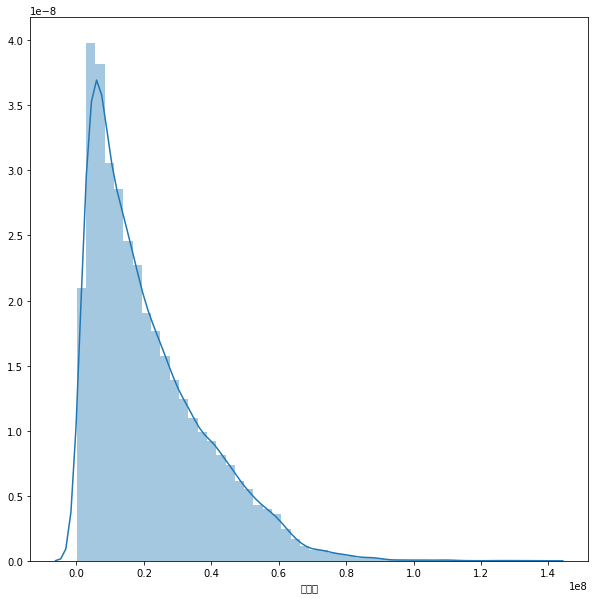

In [88]:
train3 = train.copy()
train3 = train3.loc[~train3.index.isin(outlier_index)].reset_index()
plt.figure(figsize=(10,10))
sns.distplot(train3['취급액'])

<AxesSubplot:xlabel='volume'>

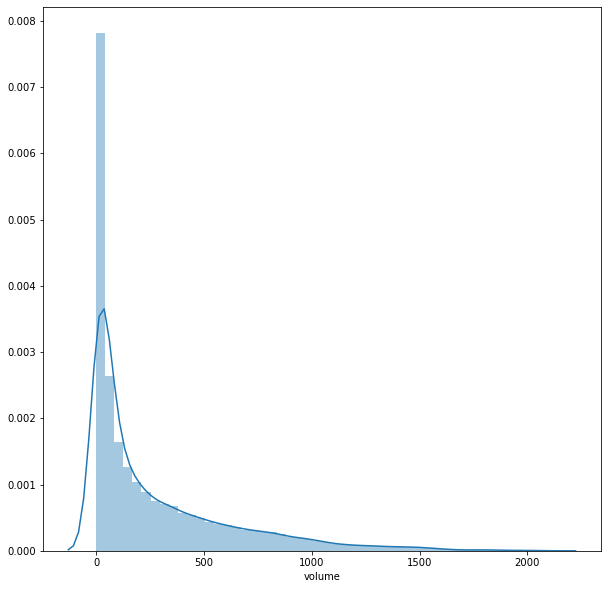

In [89]:
plt.figure(figsize=(10,10))
sns.distplot(train3['volume'])

<AxesSubplot:xlabel='판매단가'>

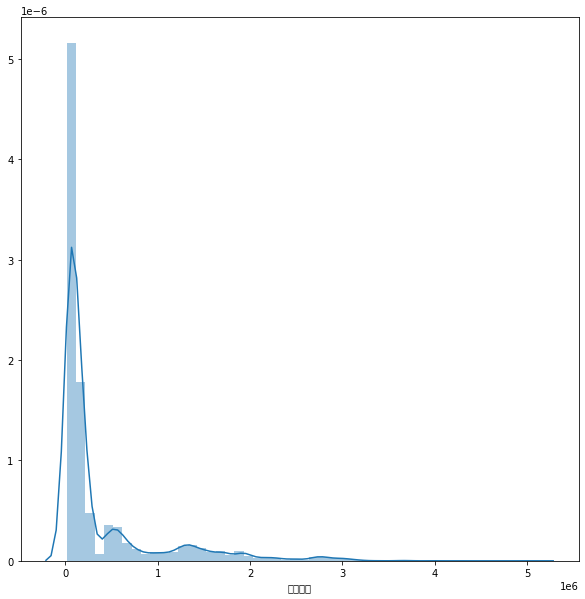

In [91]:
plt.figure(figsize=(10,10))
sns.distplot(train3['판매단가'])

# 중요! 
# 지금은 train3가 outlier/imputation 완료된 친구 
# BUT train/test(val) 나눈 후에 train에 적용해야함

# ------------------------------------------------------------------------------------

## Kmeans clustering - numeric features만 가능

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = train3.iloc[:,[11,8]]

For n_clusters = 4 The average silhouette_score is : 0.5766453535098445
For n_clusters = 5 The average silhouette_score is : 0.565022047859448
For n_clusters = 6 The average silhouette_score is : 0.5619815690956819


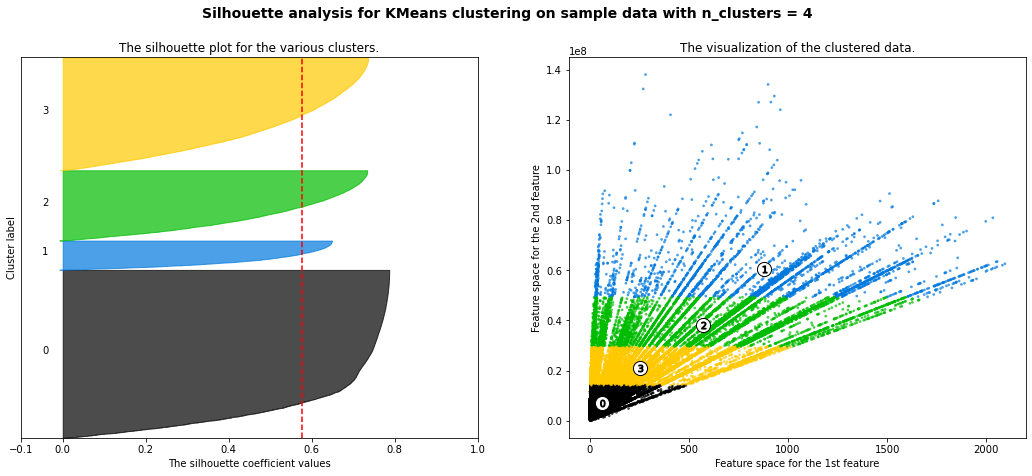

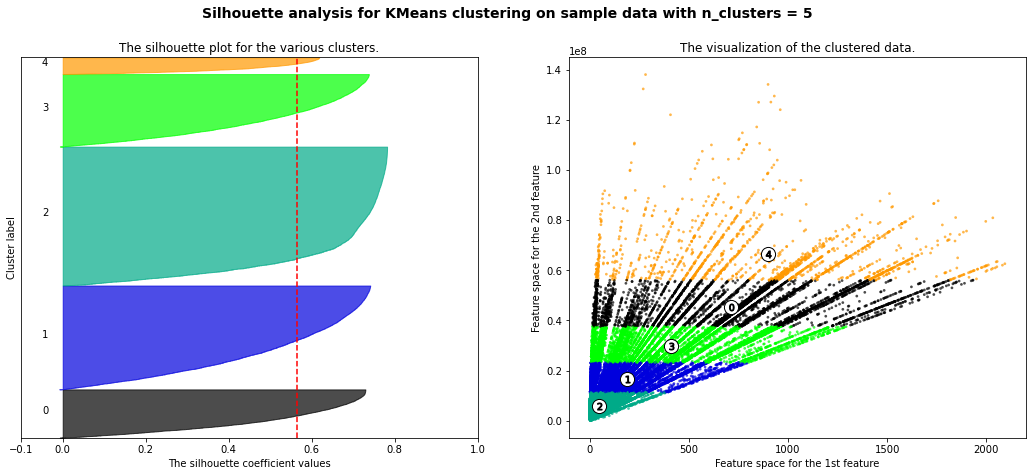

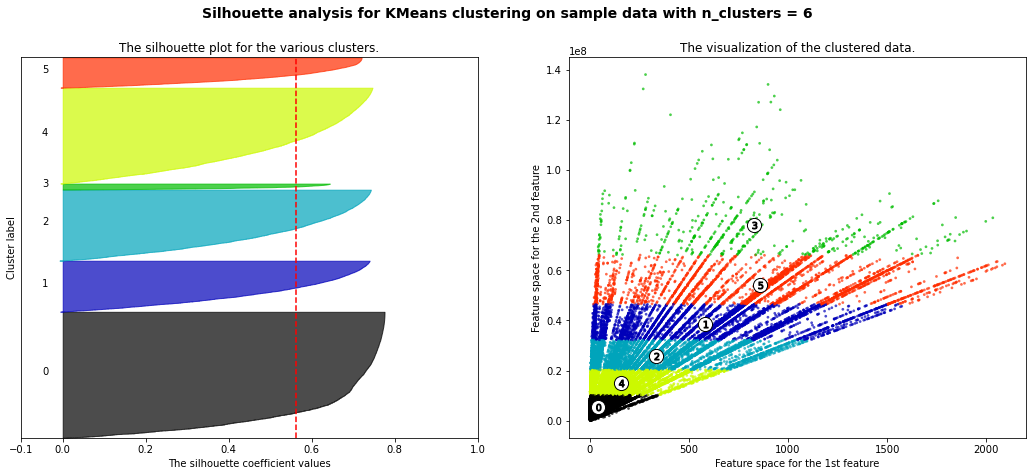

In [103]:
range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:,0], X.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [105]:
X = train3.iloc[:,[18,8]]

For n_clusters = 4 The average silhouette_score is : 0.5766453572407654
For n_clusters = 5 The average silhouette_score is : 0.5650220531999205
For n_clusters = 6 The average silhouette_score is : 0.5619815757514282


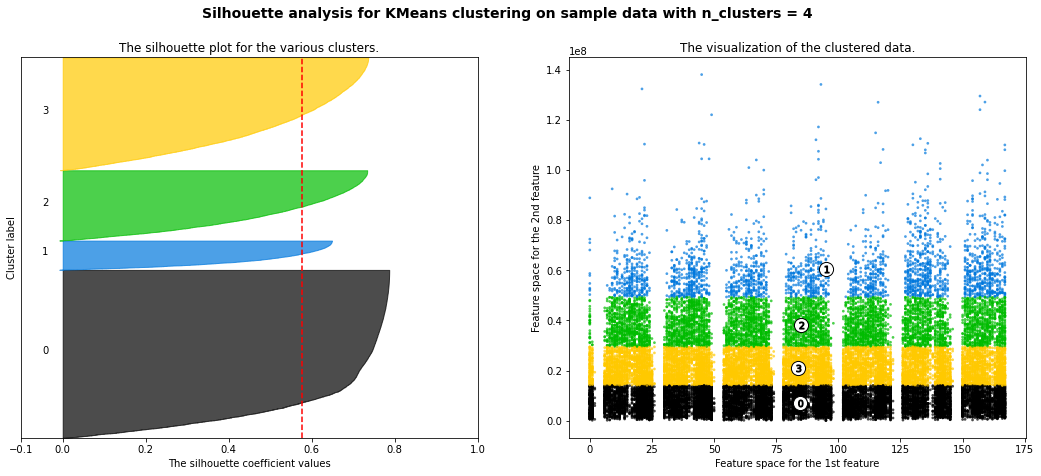

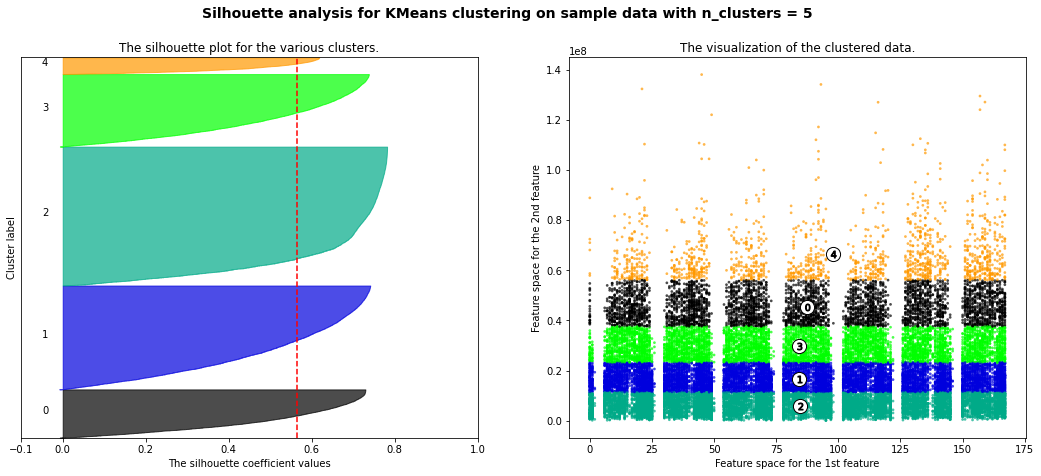

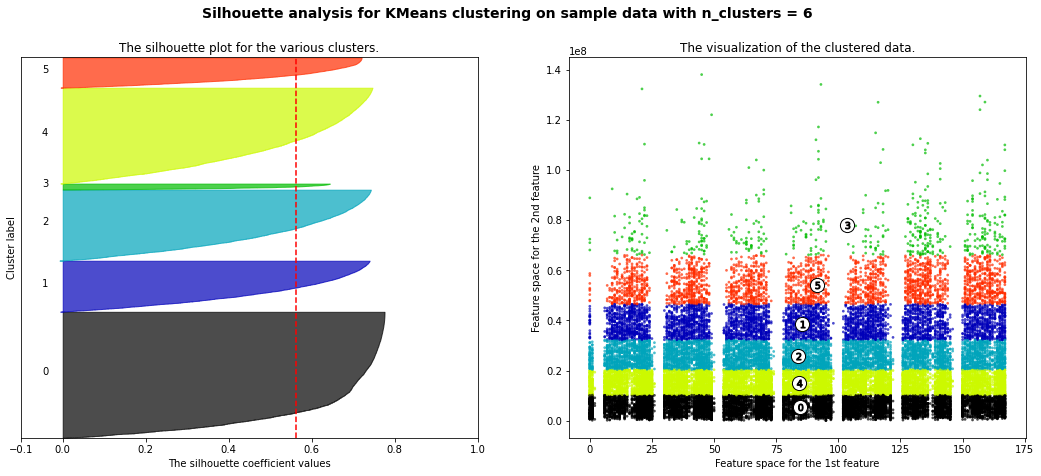

In [106]:
range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:,0], X.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 35378
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   방송일시                  35379 non-null  datetime64[ns]
 1   노출(분)                 20403 non-null  float64       
 2   마더코드                  35379 non-null  object        
 3   상품코드                  35379 non-null  object        
 4   상품명                   35379 non-null  object        
 5   상품군                   35379 non-null  object        
 6   판매단가                  35379 non-null  float64       
 7   취급액                   35379 non-null  float64       
 8   exposed               35379 non-null  float64       
 9   ymd                   35379 non-null  object        
 10  volume                35379 non-null  float64       
 11  years                 35379 non-null  int64         
 12  months                35379 non-null  int64         
 13  days            

## not for model

> 방송일시 

> 노출(분)

> 상품명

> years

> days

> hours

> week_num

> weekends

> red

> brand

> original_c

> sales_power


## for model , high cardinality (above 20)

> 마더코드 x

> 상품코드 x

> exposed dummy 20 30 기준

> ymd x

> hours_inweek -168 

> min_start 20분 단위 반올림

> min_range x

> show_id - 뒤에 숫자로 바꾸기

> small_c / middle_c 고대로 넣기

## for model, no issue

> 상품군

> 판매단가

> months

> weekdays

> holidays

> japp

> parttime

> big_c

> prime ~

> lag ~

> freq

> dup_times

> 그 외 52~66

## volume?

> volume 쓰지말자

In [122]:
pd.value_counts(train3['dup_times'])

    33610
Name: dup_times, dtype: int64

In [ ]:
X = train3.iloc[:,[37,8]]

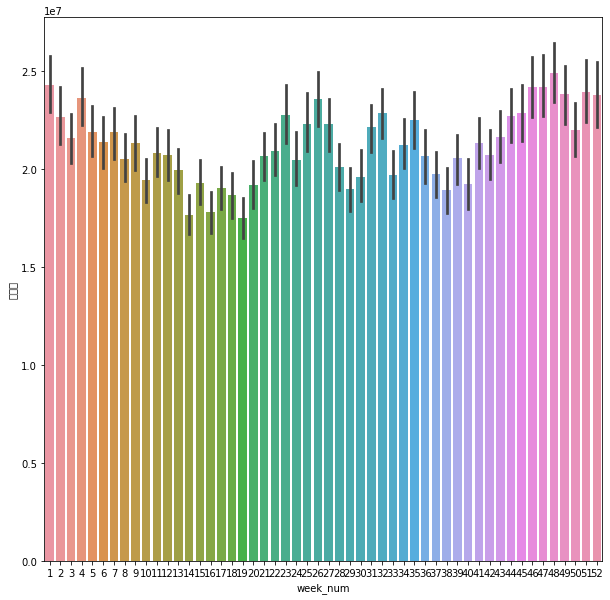

In [124]:
plt.figure(figsize=(10,10))
sns.barplot(x="week_num", y="취급액", data=train3)
plt.show()

In [134]:
pd.value_counts(train3['freq'])

0    31712
1     1898
Name: freq, dtype: int64

## 실적데이터